# LDO automation DEMO

LDO characteristics:

1. Vdd = 1.8v
2. Vreg = 1.2v
3. Vref = 0.8v
4. IL = 5mA
5. cL = 5pF

Especifications requirements:

1. LG > 100
2. PM > 90
3. Load Regulation -> minimize
4. PSRR -> minimize

In [21]:
import numpy as np
import ldo_mna as mna
from gmid.mosplot import load_lookup_table
import matplotlib.pyplot as plt
import sympy as sym

In [22]:
## LDO operation point
Vreg = 1.2                                     # LDO output voltage
Vdd = 1.8                                      # LDO supply voltage
Vref = 0.8                                     # LDO voltage reference
R1 = 100000                                    # Resistance 1, could be changed to meet size specifications
iq = 0.0000015                                 # Current through the OTA. (it depends on the pre-designed OTA)
R2 = int(R1/((Vreg/Vref)-1))                   # R2 as a function of the voltage ratio
il = 5e-3                                      # Load current
cl = 5e-12                                     # Load capacitance

## OTA Definition (we have to design the algorithm to get the operation point for any given OTA)

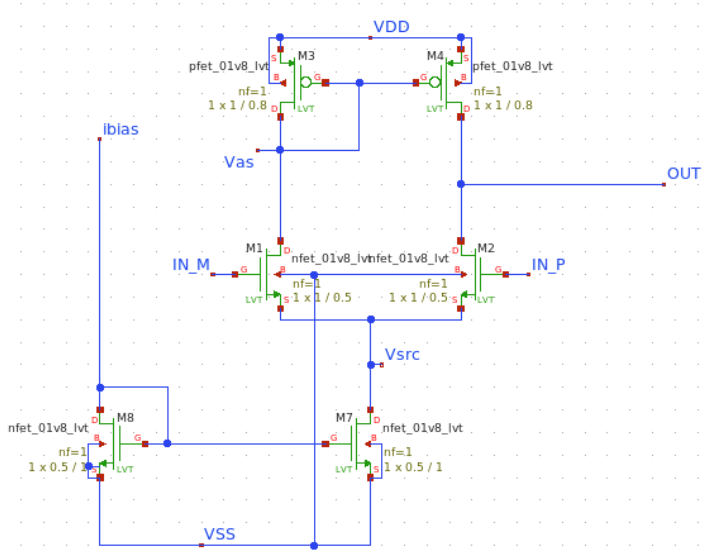

In [23]:
## Values taken from xschem DC simulation (this should be automatic)
M_1a = mna.Transistor("nmos", gm=1.3385e-05, gds=1.1652e-07, cgs=1.7e-15, cgd=2.5e-19)
M_1b = mna.Transistor("nmos", gm=1.517e-05, gds=1.69e-07, cgs=1.7e-15, cgd=2.51e-19)

M_2a = mna.Transistor("pmos", gm=6.7641e-06, gds=1.856e-07, cgs=2.4e-15, cgd=9.87e-19)
M_2b = mna.Transistor("pmos", gm=7.4378e-06, gds=1.538e-07, cgs=2.4e-15, cgd=9.87e-19)

M_4a = mna.Transistor("pmos", gm=1.65e-05, gds=1.97e-07, cgs=2.11e-15, cgd=8.35e-17)
M_4b = mna.Transistor("pmos", gm=1.583e-05, gds=5.32e-07, cgs=2.12e-15, cgd=2.72e-18)

## Pass Transistor exploration

In [24]:
lookup_table = load_lookup_table("sky130A_LUT.npy")

In [25]:
## LDO exploration parameters (this vakues can be change as the user see fit)
lengths = [0.4e-06, 0.6e-06, 0.8e-06, 1.6e-06]      # Length exploration values.
gmid_sweep = np.arange(5,25,0.2)               # gm/id sweep for exploration.
pass_transistor = mna.pass_transistor_exploration(lookup_table, Vdd, Vreg, il, R1, R2, lengths, gmid_sweep)

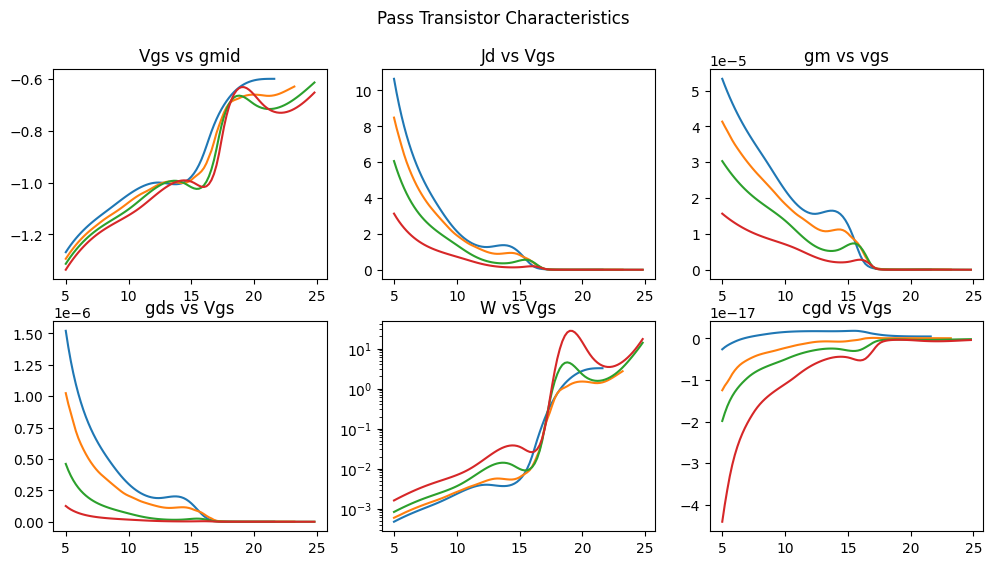

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(12, 6))
fig.suptitle('Pass Transistor Characteristics')
for index, val in enumerate(lengths):
    axs[0, 0].plot(gmid_sweep, pass_transistor.vgs[index,:])
axs[0, 0].set_title('Vgs vs gmid')
for index, val in enumerate(lengths):
    axs[0, 1].plot(gmid_sweep, pass_transistor.Jd[index,:])
axs[0, 1].set_title('Jd vs Vgs')
for index, val in enumerate(lengths):
    axs[0, 2].plot(gmid_sweep, pass_transistor.gm[index,:])
axs[0, 2].set_title('gm vs vgs')
for index, val in enumerate(lengths):
    axs[1, 0].plot(gmid_sweep, pass_transistor.gds[index,:])
axs[1, 0].set_title('gds vs Vgs')
for index, val in enumerate(lengths):
    axs[1, 1].plot(gmid_sweep, pass_transistor.W[index,:])
axs[1, 1].set_title('W vs Vgs')
for index, val in enumerate(lengths):
    axs[1, 2].plot(gmid_sweep, pass_transistor.cgd[index,:])
axs[1, 2].set_title('cgd vs Vgs')
axs[1,1].set_yscale('log')

## PSRR

In [27]:
pm_restriction = 90
LG_restriction = 100

In [28]:
## Matrix G: DC (only pasives)
G = mna.get_G_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2)
## Matrix B of the system (all the DC sources are shut down -> to get PSRR)
B = sym.Matrix([0, 0, 0, 0, 0, 0, 0, 1, 0, 0])    #(v1, v2, v3, v4, v5, v6, v8, Ibias, vdd, vref, v9) 
print(G)

Matrix([[gds_3 + gm_3 + 1.45413e-5, -1.43875000000000e-5, -gm_3 - 1.538e-7, 0, 0, 0, 0, -1, 0, -gds_3], [-6.94970000000000e-6, 7.06622000000000e-6, 0, -1.35015200000000e-5, 0, 1.33850000000000e-5, 0, 0, 0, 0], [-7.59160000000000e-6, 7.43780000000000e-6, 3.22800000000000e-7, -1.53390000000000e-5, 1.51700000000000e-5, 0, 0, 0, 0, 0], [0, -1.16520000000000e-7, -1.69000000000000e-7, 2.93725200000000e-5, -1.51700000000000e-5, -1.33850000000000e-5, 1.58300000000000e-5, 0, 0, 0], [0, 0, 0, 0, 1.50000000000000e-5, 0, 0, 0, 0, -1.00000000000000e-5], [0, 0, 0, 0, 0, 0, 0, 0, -1, 0], [0, 0, 0, 0, 0, 0, 1.66970000000000e-5, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0], [-gds_3 - gm_3, 0, gm_3, 0, -1.00000000000000e-5, 0, 0, 0, 0, gds_3 + 1.0e-5]])


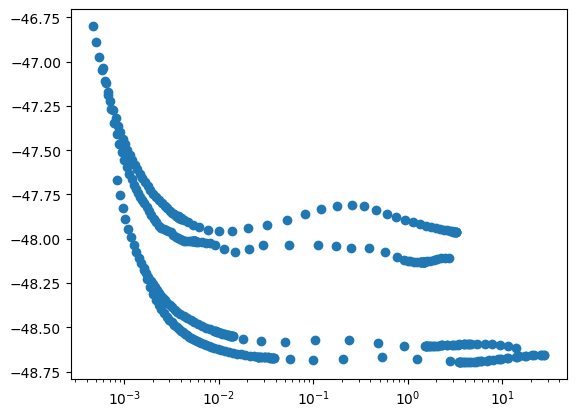

In [32]:
# 1. Lambdify the matrix so the parameters of the Pass Transistor can be replaced
gm_3 = sym.Symbol('gm_3')
gds_3 = sym.Symbol('gds_3')
PSRR_DC_lamb = sym.lambdify([gm_3, gds_3],(G.inv()*B)[9])
#print(PSRR_DC_lamb(np.multiply(M_3.gm, M_3.W*1e6), np.multiply(M_3.gds, M_3.W*1e6)))

# 2. Evaluation of the parameters into the transfer functioon matrix
## (IMPORTANt) The gm and gds must be scaled respect the W of the LUTs transistors. In other words, gm and gds must be mul by the PT W.
PSRR_DC = 20*np.log10((-1*PSRR_DC_lamb(np.multiply(pass_transistor.gm, pass_transistor.W*1e6), np.multiply(pass_transistor.gds, pass_transistor.W*1e6))))
## Second function to optimize, considering the PSRR as the first one.
L = sym.Symbol('L')
W = sym.Symbol('W')
Area = sym.lambdify([L, W], L+W)   # Total area of the pass transistor

lengths_reshaped = np.transpose(np.tile(l3, (100,1)))
f_2 = Area(lengths_reshaped, pass_transistor.W)

f_1 = PSRR_DC

plt.scatter(f_2,f_1)
plt.xscale('log')

In [ ]:
C = mna.get_openloop_C_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2, 1e-15)
G = mna.get_openloop_G_matrix(M_1a, M_1b, M_2a, M_2b, M_4a, M_4b, R1, R2)

cgs_3 = sym.Symbol('cgs_3')
cgd_3 = sym.Symbol('cgd_3')
s = sym.Symbol('s')
C_lamb = sym.lambdify([cgs_3, cgd_3, s], C)

gm_3 = sym.Symbol('gm_3')
gds_3 = sym.Symbol('gds_3')
G_lamb = sym.lambdify([gm_3, gds_3], G)

pm = []
for idx, value in enumerate(np.ndarray.flatten(M_3.W)):
    cgs = np.ndarray.flatten(M_3.cgs)[idx]*value*1000*10
    cgd = np.ndarray.flatten(M_3.cgs)[idx]*value*1000*10
    gm = np.ndarray.flatten(M_3.gm)[idx]*value*1000
    gds = np.ndarray.flatten(M_3.gds)[idx]*value*1000

    if(np.isnan(value) or np.isnan(cgs) or np.isnan(cgd) or np.isnan(gm) or np.isnan(gds)):
        print("INVALID")
        pm.append(0)
    else:
        G = G_lamb(gm, gds)
        pm.append(get_PM(s_sweep, G, C_lamb, B, idx, 0, 6, cgs, cgd))
    print(pm[-1])